<a href="https://colab.research.google.com/github/giuliapuntoit/CapsnetGoogleLandmark/blob/main/project_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [ ]:
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip3 install 'livelossplot'
!pip3 install --upgrade 'pillow'


     |████████████████████████████████| 634kB 3.4MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110367 sha256=6ab1859223c0714246abb4fd001364d0d84b5a4744192a8d002bd23ed68d0389
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


     |████████████████████████████████| 2.1MB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import vgg16_bn
from torchvision.models import densenet161
from torchvision.models import resnet50

from PIL import Image

from tqdm import tqdm

from livelossplot import PlotLosses

import copy

from datetime import datetime

**Download images**

In [ ]:
# Note to Kagglers: This script will not run directly in Kaggle kernels. You
# need to download it and run it on your local machine.

# Downloads images from the Google Landmarks dataset using multiple threads.
# Images that already exist will not be downloaded again, so the script can
# resume a partially completed download. All images will be saved in the JPG
# format with 90% compression quality.

import sys, os, multiprocessing, csv
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
import torch
from torchvision import transforms


def ParseData(data_file):
    csvfile = open(data_file, 'r')
    csvreader = csv.reader(csvfile)
    key_url_label_list = [line[:3] for line in csvreader] # prima era :2 -> non capisco se splitta in orizzontale o verticale
    return key_url_label_list  # Chop off header


def DownloadImage(key_url_label, out_dir):
    line = key_url_label
    #(key, url, label) = key_url_label
    key = line[0]
    url = line[1]
    label = line[2]
    out_lab = os.path.join(out_dir, label)
    filename = os.path.join(out_lab, '%s.jpg' % key)

    print(out_lab)
    if not os.path.isdir(out_lab):
      os.mkdir(out_lab)

    p = transforms.Compose([transforms.Resize((224, 224))])

    if os.path.exists(filename):
        print('Image %s already exists. Skipping download.' % filename)
        return

    try:
        response = urlopen(url)
        image_data = response.read()
    except:
        print('Warning: Could not download image %s from %s' % (key, url))
        return

    try:
        pil_image = Image.open(BytesIO(image_data))
    except:
        print('Warning: Failed to parse image %s' % key)
        return
    try:
        pil_image_rgb = pil_image.convert('RGB')
        pil_image_rgb = p(pil_image_rgb)
    except:
        print('Warning: Failed to convert image %s to RGB' % key)
        return

    try:
        pil_image_rgb.save(filename, format='JPEG')
    except:
        print('Warning: Failed to save image %s' % filename)
        return


def Run(data_file, out_dir):
    #if len(sys.argv) != 3:
    #    print('Syntax: %s <data_file.csv> <output_dir/>' % sys.argv[0])
    #    sys.exit(0)
    #(data_file, out_dir) = sys.argv[1:]

    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    key_url_label_list = ParseData(data_file)
    #pool = multiprocessing.Pool(processes=50)
    #pool.map(DownloadImage, key_url_label_list, out_dir)
    for element in key_url_label_list:
      #print(element)
      DownloadImage(element, out_dir)


#if __name__ == '__main__':
#    Run()


**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 50     # 50 selected classes for now

BATCH_SIZE = 16      # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# FORSE QUI CI SONO DELLA TRANSFORM SUPERFLUE
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                  # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation

])

# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                   
])


**Prepare Dataset**

In [ ]:
FMT = '%H:%M:%S'
now = datetime.now()
time1_before_download = now.strftime(FMT)
print(time1_before_download)

# Clone github repository with data
if not os.path.isdir('./landmark-recognition'):
  !git clone https://github.com/davidetadz/landmark-recognition.git

data_file = './landmark-recognition/train_filter.csv'
out_dir = './landmark-recognition/train_img_folder/'

Run(data_file, out_dir)

DATA_DIR = 'landmark-recognition/train_img_folder/'

# Prepare Pytorch train/test Datasets
train_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=train_transform) # probably da cambiare e usare le funzioni che ho scritto
test_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=eval_transform)

#train_dataset = Landmark(root='landmark-recognition', split='train', transform=train_transform)
#test_dataset = Landmark(root='landmark-recognition', split='test', transform=eval_transform)

#half_train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2]
#half_val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 2]
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

#half_train_dataset = Subset(train_dataset, half_train_indexes)
#half_val_dataset = Subset(train_dataset, half_val_indexes)

train_dataset = Subset(train_dataset, train_indexes)
test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

#print('Half train Dataset: {}'.format(len(half_train_dataset)))
#print('Half val Dataset: {}'.format(len(half_val_dataset)))

now = datetime.now()
time2_after_download = now.strftime(FMT)
print(time2_after_download)

11:22:57
Cloning into 'landmark-recognition'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 28 (delta 0), reused 5 (delta 0), pack-reused 23
Unpacking objects: 100% (28/28), done.
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recognition/train_img_folder/456
./landmark-recogn

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# here i should load half_train_dataset and half_val_dataset instead of train and test datasets
#train_dataloader = DataLoader(half_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#val_dataloader = DataLoader(half_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [ ]:
# try with vgg16_bn, googlenet, alexnet, resnet 
# net = vgg16_bn(pretrained=True) # VGG 16-layer model (configuration “D”) with batch normalization
# net = alexnet(pretrained=True)
# net = densenet161(pretrained=True)
net = resnet50(pretrained=False)

print(net)

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 50 outputs for this VGG
# AlexNet and VGG16
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
# Resnet50
net.fc = nn.Linear(2048, NUM_CLASSES)

# DenseNet161
#net.classifier = nn.Linear(2208, NUM_CLASSES)

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
liveloss = PlotLosses()

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  logs = {}
  net.train(True) # Set Network to training mode
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  train_running_corrects = 0
  train_running_loss = 0.0
  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    train_running_loss += loss.detach() * images.size(0)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    train_running_corrects += torch.sum(preds == labels.data).data.item()

    current_step += 1
  

  # Calculate Loss and Accuracy
  epoch_train_loss = train_running_loss / len(train_dataset)
  epoch_train_acc = train_running_corrects / float(len(train_dataset))

  print('Training Accuracy at epoch {}: {}'.format(epoch+1, epoch_train_acc))

  logs['' + 'Loss'] = epoch_train_loss
  logs['' + 'Accuracy'] = epoch_train_acc

  liveloss.update(logs)
  #liveloss.draw()
  # Step the scheduler at each epoch
  scheduler.step() 
  # go to next epoch

now = datetime.now()
time3_after_training = now.strftime(FMT)
print(time3_after_training)

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.020536422729492
Step 10, Loss 3.8961479663848877
Step 20, Loss 4.131255626678467
Step 30, Loss 4.407083988189697
Step 40, Loss 4.305432319641113
Step 50, Loss 4.112790584564209
Step 60, Loss 4.239743709564209
Step 70, Loss 4.3612260818481445
Step 80, Loss 3.7402350902557373
Step 90, Loss 3.990255117416382
Step 100, Loss 4.072652816772461
Step 110, Loss 4.211474418640137
Step 120, Loss 4.097210884094238
Step 130, Loss 4.0196146965026855
Step 140, Loss 4.088695049285889
Step 150, Loss 3.8207571506500244
Step 160, Loss 4.021755695343018
Step 170, Loss 3.8134067058563232
Step 180, Loss 4.25119686126709
Step 190, Loss 4.0117363929748535
Step 200, Loss 3.8872084617614746
Step 210, Loss 3.6891465187072754
Training Accuracy at epoch 1: 0.0333716915995397
Starting epoch 2/30, LR = [0.001]
Step 220, Loss 3.6657986640930176
Step 230, Loss 3.7526698112487793
Step 240, Loss 4.065844535827637
Step 250, Loss 4.3308281898498535
Step 260, Loss 4.46533775

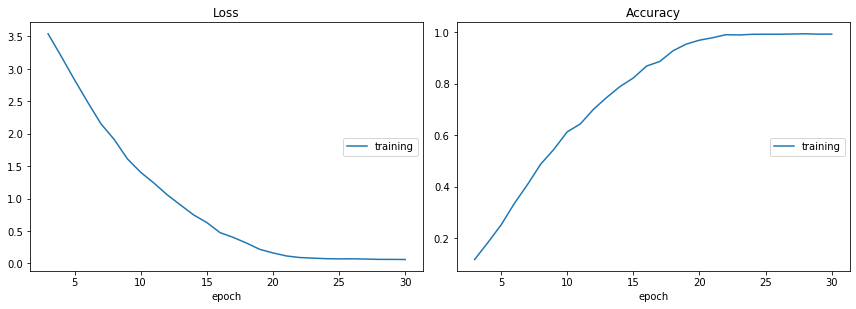

Loss:
training   (min:    0.061, max:    4.100, cur:    0.061)

Accuracy:
training   (min:    0.033, max:    0.993, cur:    0.992)


In [ ]:
liveloss.draw() #plot graphs

**Test**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

now = datetime.now()
time4_after_testing = now.strftime(FMT)
print(time4_after_testing)

delta_download = datetime.strptime(time2_after_download, FMT) - datetime.strptime(time1_before_download, FMT)
delta_training = datetime.strptime(time3_after_training, FMT) - datetime.strptime(time2_after_download, FMT)
delta_testing = datetime.strptime(time4_after_testing, FMT) - datetime.strptime(time3_after_training, FMT)

print('Time to download:\t{}'.format(delta_download))
print('Time to train:\t\t{}'.format(delta_training))
print('Time to test:\t\t{}'.format(delta_testing))

100%|██████████| 55/55 [00:03<00:00, 17.45it/s]

Test Accuracy: 0.8022988505747126
12:00:19
Time to download:	0:26:12
Time to train:		0:11:06
Time to test:		0:00:04
